In [1]:
from math import sqrt
from scipy.stats import chi2_contingency
import pandas as pd

bookings_file = r'/home/beastman/Projects/HomeSchool/data-analysis/BehavioralDataAnalysis/Chapter 4 - Building Causal Diagrams From Scratch/chap4-hotel_booking_case_study.csv'
bookings = pd.read_csv(bookings_file)

bookings.head()

,NRDeposit,IsCanceled,DistributionChannel,MarketSegment,CustomerType,Children,ADR,PreviousCancellations,IsRepeatedGuest,Country,Quarter,Year
0,0,0,Direct,Direct,Transient,0,0.0,0,0,PRT,Q3,2015
1,0,0,Direct,Direct,Transient,0,0.0,0,0,PRT,Q3,2015
2,0,0,Direct,Direct,Transient,0,75.0,0,0,GBR,Q3,2015
3,0,0,Corporate,Corporate,Transient,0,75.0,0,0,GBR,Q3,2015
4,0,0,TA/TO,Online TA,Transient,0,98.0,0,0,GBR,Q3,2015


In [2]:
table_cnt = bookings.groupby(['NRDeposit','IsCanceled']).agg(cnt = ('Country', lambda x: len(x)))

table_cnt

cnt
NRDeposit IsCanceled       
0         0           63316
          1           23042
1         0              55
          1             982

In [3]:
table_pct = table_cnt.groupby(level=0).apply(lambda x: 100 * x/float(x.iloc[:,0].sum())).droplevel(0)

table_pct

cnt
NRDeposit IsCanceled           
0         0           73.318048
          1           26.681952
1         0            5.303761
          1           94.696239

<Axes: >

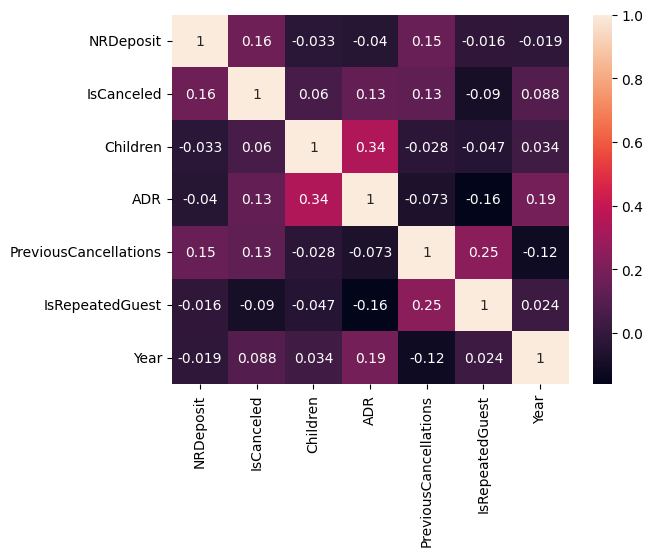

In [4]:
import seaborn as sns

num = bookings.copy().select_dtypes('number')
cat = bookings.copy().select_dtypes('object')

corr_df = num.corr()

sns.heatmap(corr_df, annot=True)

In [5]:
from scipy.stats import chi2_contingency as X2
import numpy as np

# expects a dataset being a 2D numpy array

def cramer_v(dataset: np.ndarray):
	V = np.sqrt(
		(X2(dataset, correction=False)[0] / dataset.sum()) / 
		(min(dataset.shape) - 1)  
	)
	return V

In [6]:
ctab = pd.crosstab(bookings["NRDeposit"], bookings["IsCanceled"]).to_numpy()

cramer_v(ctab)

0.16495780829080092

In [7]:
catdf = cat.join(bookings[["NRDeposit", "IsCanceled", "PreviousCancellations"]]).copy().apply(lambda x: x.astype('category'))

catdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87395 entries, 0 to 87394
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   DistributionChannel    87395 non-null  category
 1   MarketSegment          87395 non-null  category
 2   CustomerType           87395 non-null  category
 3   Country                86943 non-null  category
 4   Quarter                87395 non-null  category
 5   NRDeposit              87395 non-null  category
 6   IsCanceled             87395 non-null  category
 7   PreviousCancellations  87395 non-null  category
dtypes: category(8)
memory usage: 774.9 KB


In [8]:
catdf.rename(columns= {
    "CustomerType": "CustTyp",
    "DistributionChannel": "DistCh",
    "IsRepeatedGuest": "RepGst",
    "MarketSegment": "MktSgmt",
    "IsCanceled": "IsCanc",
    "PreviousCancellations": "PrevCan",
    "NRDeposit": "NRDep"
}, inplace=True)

In [9]:
def cat_corr(df: pd.DataFrame):
    cat_matrix = pd.DataFrame(columns=["VarX","VarY","corr"])
    for x in df.columns:
        for y in df.columns:
            tab = pd.crosstab(catdf[x], catdf[y]).to_numpy()
            corr = cramer_v(tab)
            # convert series into row-formatte dataframe to concatenate onto main frame
            row = pd.Series(data={"VarX":x,"VarY":y,"corr":corr}).to_frame().T 
            # append deprecated, concat transposed row instead
            cat_matrix = pd.concat([cat_matrix, row], ignore_index=True)
    
    return cat_matrix
        

<Axes: xlabel='VarX', ylabel='VarY'>

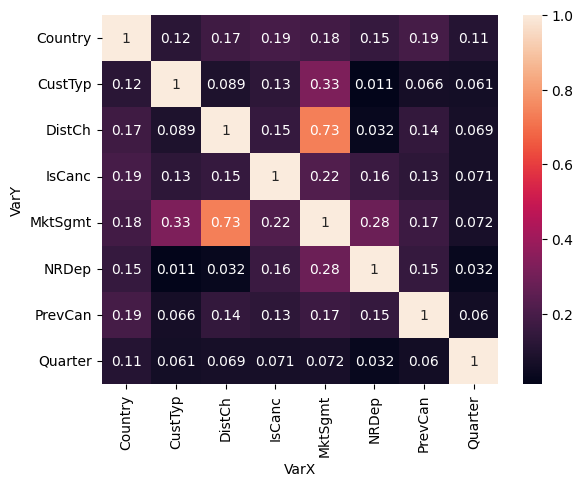

In [10]:
cat_corrs = pd.pivot_table(cat_corr(catdf), index=["VarY"], columns=["VarX"], values=["corr"], fill_value=1)

cat_corrs.columns = cat_corrs.columns.droplevel(0)

sns.heatmap(cat_corrs, annot=True)

In [16]:
df = bookings.copy()
df.rename(columns= {
    "CustomerType": "CustTyp",
    "DistributionChannel": "DistCh",
    "IsRepeatedGuest": "RepGst",
    "MarketSegment": "MktSgmt",
    "IsCanceled": "IsCanc",
    "PreviousCancellations": "PrevCan",
    "NRDeposit": "NRDep"
}, inplace=True)

df.groupby('CustTyp').agg(ADR = ('ADR', 'mean'))

,ADR
CustTyp,
Contract,92.753036
Group,84.361949
Transient,110.062373
Transient-Party,87.675056
